In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import math

from johansen import coint_johansen



In [3]:
#df = pickle.load(open('D:/Machine_learning_finance/raw_data/INDICATORS_ADDED_period_5m_pulledAt_1548295114__ETH_BTC_BTC_USDT_2019-01-24T015500000000000_to_2015-08-08T051000000000000.pickle','rb'))

df_1d = pickle.load(open('D:/Machine_learning_finance/raw_data/INDICATORS_ADDED_period_1d_pulledAt_1548466826__ETH_BTC_BTC_USDT_XMR_BTC_2019-01-26T000000000000000_to_2015-08-08T000000000000000.pickle','rb'))
df_1d = df_1d[['ETH/BTC_Close','BTC/USDT_Close', 'XMR/BTC_Close']]
df_1d = df_1d.dropna()

df_5m = pickle.load(open('D:/Machine_learning_finance/raw_data/INDICATORS_ADDED_period_5m_pulledAt_1547039178__ETH_BTC_BTC_USDT_XMR_BTC_2019-01-09T130000000000000_to_2015-08-08T051000000000000.pickle','rb'))
df_5m = df_5m[['ETH/BTC_Close','BTC/USDT_Close', 'XMR/BTC_Close']]
df_5m = df_5m.dropna()

df_ernie = pd.read_csv('D:/Machine_learning_finance/raw_data/ewaewcige.csv')
df_ernie.set_index('Date',inplace=True)

df_glduso = pd.read_csv('D:/Machine_learning_finance/raw_data/glduso.csv')
df_glduso = df_glduso.set_index('Date')

## Hurst Exponent
Following a post on https://stackoverflow.com/questions/39488806/hurst-exponent-in-python, if H<0.5 the series is mean reverting, if H>0.5 it's trending. If H=0.5, its a geometric walk. We will use the following function to test this on some time series.

In [15]:
def hurst(ts):

    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    # Here it calculates the variances, but why it uses 
    # standard deviation and then make a root of it?
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# print('Ethereum and BTC have a hurst ratio of:',hurst(df['ETH/BTC_Close']))
# print('Ethereum and BTC have a hurst ratio of:',hurst(df['BTC/USDT_Close']))

With Hurst ratios of 0.4-0.5 for both time series, we see that the time series is weakly mean reverting. We can then test their significance using a variance ratio test, as seen in the following code.

## Half life of mean reversion
We describe the price changes using a linear model:
$ \Delta y(t) = \lambda y(t-1) + \mu + \beta t + a_{1} \Delta y(t-1)+ ... + \alpha_{k} \Delta y(t-k) + \epsilon_{t}$
, where $\Delta y(t) = y(t) - y(t-1), \Delta y(t-1) = y(t-1) - y(t-2)$ and so on. Notice that $\mu + \beta t$ is a simple linear model. If $\lambda = 0$, then there is no relationship between the current move and the previous time step. This is what the CADF test (for multiple time series) - testing the hypothesis that a vector of lambdas is zero. For now, however, we'll focus of the mean reversion half life. Even if we can't reject the null hypothesis with a significance of 0.05 for example, we can know that it will whether it is large enough or not to make a trading strategy from it. If we put the above formula into differential form, and ignore drift and lag terms ($\beta t, \Delta y(t-1), \Delta y(t-2), ..., \Delta y(t-k)$), then this formula simply becomes the Ornstein-Uhlenbeck formula for a mean reverting process: $dy(t) =  (\lambda y(t-1) + \mu)dt + d\epsilon$. From this, we can derive an expected value for the value of y(t): $E(y(t)) = y_0e^{\lambda t} - \frac{\mu}{\lambda}(1-e^{\lambda t})$. 
$\lambda$ will be negative for a mean reverting process, so this formula tells us that the expected value of the price dacays exponentially to the value $\frac{-\mu}{\lambda}$ with a half life of decay of $-\frac{log(2)}{\lambda}$. This indicates a few key properties:
1. If $\lambda$ is > 0, then the series isn't even mean reverting and shouldn't be traded.
2. If $\lambda$ is < 0, but close to zero, we will have a long half time of mean reversion.
3. $\lambda$ determines a natural time-scale for our strategies, for example if $\lambda$ is 50, we shouldn't use a lookback of 5 days for our moving average.

Easy. To determine $\lambda$, we run a regression fit with y(t)-y(t-1) as the dependent variable, and y(t-1) as the independent.

In [2]:

def halfLife_coint(A, evec):
    #marketVal is the sum of the value of a portfolio where we own an amount of units of each stock proportional to the value given in the eigenvector at each timeframe.
    #We obtain this by finding the dot product of the array inputted and the eigenvector. For some reason it optputs a row vector, so we transpose it too.
    marketVal = np.transpose(dot(A,evec))

    #marketValChange is the difference in the market value at each time step
    marketValChange = np.diff(marketVal,axis=0)

    #Add a list of 1's so we have an intercept
    marketVal_withOnes = np.hstack([marketVal[1:],np.ones((len(marketVal[1:]),1))])

    #regress these bad boys
    beta = np.linalg.lstsq(marketVal_withOnes, marketValChange, rcond=1)
    half_life = log(2) / beta[0]
    return half_life[0], marketVal, evec

def half_life(y):
    lag = y.shift(1)
    lag[0]=0
    deltaY = y-lag
    deltaY[0]=0
    lagConst = sm.add_constant(lag) # adds a intercept value to the x variable
    model = sm.OLS(list(deltaY), lagConst)
    res = model.fit()
    halfLife = -math.log(2)/res.params[1]
    return halfLife

# print(half_life(df['ETH/BTC_Close'])/(12*24))
# print(half_life(df_ernie['ewc']))

A HalfLife of 152 days for the ewc ETF data is pretty realistic, however for the Ethereum/Bitcoin closing prices, the half life is 35853 5 minute tickers, which is around 121 days. Seems pretty realistic too actually.

## Cointegration
Most time series on their own are not stationary, so we cannot use a mean reverting strategy. However, we can cointegrate multiple assets' time series to create a stationary portfolio. The problem is that this portfolio will have hedge ratios for each asset, which we need to figure out (i.e. how many of units of each asset to we need to own in order to make our time series stationary). We're pretty much trying to find a linear combination of several non stationary price series that is in total - stationary. So to the good bit: how do we find the hedge ratios?
### 2 assets - CADF test
We can use the regression fit (if there is a fit) coefficient(s) as the hedge ratio. To see if there is any fit:

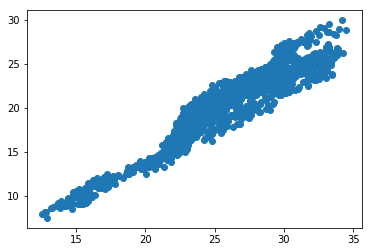

In [11]:
import matplotlib.pyplot as plt
plt.scatter(df_ernie['ewc'],df_ernie['ewa'])
plt.show()

They look fairly linearly related i guess lol.

0.9526600515607516


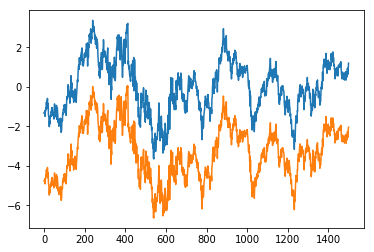

In [27]:
import statsmodels.api as sm

ewc_Const = sm.add_constant(df_ernie['ewc'].values) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
model = sm.OLS(df_ernie['ewa'].values,ewc_Const).fit()
hedge ratio = model.params[1]
hedge_ratio = 0.9095
plt.plot(model.resid) 
plt.plot(df_ernie['ewa'].values-hedge_ratio*df_ernie['ewc'].values)
plt.show()

Note that the EWC-hedge*EWA plot is identical to the residuals of the fitted model. Makes sense.
### 3 or more assets - Johansen test
We reformulate our linear fit of a mean reverting time series into matrix form:

$ \Delta Y(t) = \Lambda Y(t-1) + M + A_{1} \Delta Y(t-1)+ ... + A_{k} \Delta Y(t-k) + \epsilon_{t}$


Where $\Lambda = 0 $ indicades we have no cointegration, as there is no linear combination of $y_i$ that is mean reverting.

$Y(t)$ is a vector containing all of the time series.

$A_i and \Lambda$ are matrices.

Let's denote $r = Rank(\Lambda)$, and n as the number of price series. The number of independent portfolios that can be formed by various linear combinations of cointegrating time series is $r$. The Johansen test is a statistical test, that gives a probability that  r==0, r<=1, r<=2,... ,r<=n-1 etc. A useful bi-product is the eigenvector for $\Lambda$, which can be used as the hedge ratios for our portfolio. 

## Linear Tradimg Strategy
As a test for the potential to make profit, we try a basic trading strategy wheteby we seek to own units of a portfolio proportional to the negative z score of a "unit portfolio's" market price from its moving average:

Let $E = [e_1, e_2, ... , e_r]$ be the eigenvector containing the optimal hedge ratios (for r assets), $P_i(t)$ be the price of the $i_{th}$ commodity at time t. Now denote the market value of the portfolio at time t as $X(t)$ :  $X(t) = \sum_{i=1}^{r} x_i$, where $x_i = P_i(t) * E_i$

$$X(t) = \sum_{i=1}^{r} P_i(t)*E_i$$

Thus to calculate the Z-score of the portfolio's value at time t, $z(t)$, we take a moving average with a lookback corresponding to the half life of mean reversion,$\lambda$, and at every timestep calculate:

$$z(t) = - \frac{X(t) - movingAve(X(t))}{movingStd(X(t))}$$

[[212.99270584]]


c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


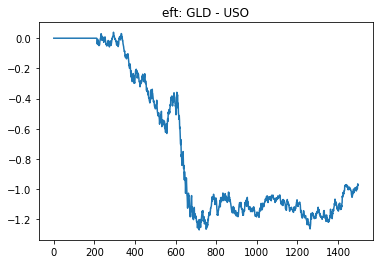

In [17]:
def halfLife_coint(A, evec):
    #marketVal is the sum of the value of a portfolio where we own an amount of units of each stock proportional to the value given in the eigenvector at each timeframe.
    #We obtain this by finding the dot product of the array inputted and the eigenvector. For some reason it optputs a row vector, so we transpose it too.
    marketVal = np.transpose(np.dot(A,evec))

    #marketValChange is the difference in the market value at each time step
    marketValChange = np.diff(marketVal,axis=0)

    #Add a list of 1's so we have an intercept
    marketVal_withOnes = np.hstack([marketVal[1:],np.ones((len(marketVal[1:]),1))])

    #regress these bad boys, regressing with y(t)-y(t-1) as the dependent variable, and y(t-1) as the independent.
    beta = np.linalg.lstsq(marketVal_withOnes, marketValChange, rcond=1)
    half_life = log(2) / beta[0]
    return half_life[0], marketVal, evec

def linearTradingStrategy(df): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    A = np.matrix(df)
    johansenTest = coint_johansen(A,0,2)
    lookback, marketVal, evec = halfLife_coint(A, johansenTest.evec[:,0])
    print(lookback)
    #test case: use the eigenvector from ernie chan's book to make sure our returns are calculated properly
    #lookback, marketVal, evec = halfLife_coint(A, np.array([-1.046,0.76,0.2233]))
    #lookback = 23
    
    #create rolling averages
    marketVal_temp = pd.DataFrame(marketVal)
    marketValStd = np.array(marketVal_temp.rolling(math.floor(lookback)).std())
    marketValMA = np.array(marketVal_temp.rolling(math.floor(lookback)).mean())
    
#     plt.plot(marketVal)
#     plt.show()
    
    #calculate negative z score from moving average
    z = -(marketVal - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))
    
    #calculate the 'positions' we would enter at each time step for each asset. i.e. multiply the number of units by the price of each asset
    #num units is a [len(A) x r] matrix, corresponding to the number of units needing to be bought (weighting by eigenvectors)
    numUnits = np.tile(evec,[len(A),1])*z
    #positions multiplies the price of each asset by the number of units seeking to be owned at each time
    positions = np.multiply(numUnits,A)
    
    #we calculate pnl by first calculating the percent change of price in each asset
    percentChange = np.array(pd.DataFrame(A).diff())/A
    #then we multiply the percent change by the value of our initial investment (previous timestep), for the pnl
    pnl = np.sum(np.multiply(np.array(pd.DataFrame(positions).shift(1)), percentChange), axis=1)
    pnl = np.nan_to_num(pnl)
    #finally, to calculate the returns, we find the value of our initial investment (divie pnl by the summed rows of positions array)
    prevInvestmentValue= np.array((pd.DataFrame(np.sum(np.abs(np.nan_to_num(np.array(pd.DataFrame(positions).shift(1)))), axis=1))))
    returns = np.divide(pnl, prevInvestmentValue)
    returns = np.nan_to_num(returns)
    
    #to calculate the cumulative returns:
    cumulativeReturns = np.cumsum(returns, axis=0)
    return cumulativeReturns

# #ernie chan's data
# plt.plot(linearTradingStrategy(df_ernie))
# plt.title('Ernie - ewa/ewc/ige')
# plt.show()

# #5m ticker data
# plt.plot(linearTradingStrategy(df_5m))
# plt.title('Crypto 5m - btc/usdt, eth/btc, xmr/btc')
# plt.show()

# #1d ticker data
# plt.plot(linearTradingStrategy(df_1d))
# plt.title('Crypto 1d - btc/usdt, eth/btc, xmr/btc')
# plt.show()

#1d ticker data
plt.plot(linearTradingStrategy(df_glduso))
plt.title('eft: GLD - USO')
plt.show()

We observe relatively similar results to dr ernie chan, with differencences likely coming from a mistake in pnl calculation or from differences in our calculated eigenvector, or differences in the data. When we run this on bitcoin/omg/eth currencies with 1 day ticker data, we see horrible cumulative returns. interesting. If we run it on 5 minute ticker data - however - we see far better results. 

### Clarifications


$\textbf{Market value}$ is the price an asset would fetch in the marketplace. It is calculated by multiplying the price of an asset by the quantity owned. Thus, the market value of a portfolio is the price of each asset multiplied by the quantity of each asset owned. Our previous strategies have worked by creating a time series in which the new market value is a stationary time series, made so by designating that we seek to own a number of units proportional to hedge ratios found by the johansen test. By activating a line of code in the linearTradingStrategy function, you can illustrate this principle, as the marketValue is visibly stationary and mean reverting for some of the time series chosen.




## Trading Pairs Using Price Spreads, Log Price Spreads, or Ratios
Recall that we valued our stationary porfolio by defining the market value as 
$$y = h_1y_1 + h_2y_2 + ... + h_ny_n$$
for $y_i$ being the value of asset i, and individual weights $h_i$, which corresponded to the number of shares of each constituent share. What if - instead - we find that the log of prices are cointegrating.Let's define a new set of weights $h_i\prime$ which are derived from a Johansen tests' eigenvectors on:
$$log(y\prime) = h_1\prime log(y_1) + h_2\prime log(y_2) + ... + h_n\prime log(y_n)$$
How do we interpret $h_i \prime$ ? First, lets take the difference:
$$\Delta log(y\prime) = h_1\prime \Delta log(y_1) + h_2\prime \Delta log(y_2) + ... + h_n\prime \Delta log(y_n)$$
Now recalling that $$\Delta log(t) = log(x(t)) - log(x(t-1)) = log(\frac{x(t)}{x(t-1)}) \approx \frac{\Delta x}{x}$$
We can write $$\Delta log(y\prime) = h_1\prime \frac{\Delta y_1}{y_1} + h_2\prime \frac{\Delta y_2}{y_2} + ... + h_n\prime \frac{\Delta y_n}{y_n}$$
We see that $\Delta log(y\prime)$ is now the returns of a portfolio of n assets, with weights $h_i\prime$. Unlike the $h_i$ top equation which refer to the number of shares of each asset, we can set the market value of each asset to $h_i\prime$. Hence, the new equation,$ y\prime $, can be interpreted as the market value of a portfolio of assets with prices $y_i$ with constant capital weights $h_i \prime$. We're now dealing with the log price spread.  A stationary price spread means that prices differences are mean-reverting, a stationary $\textbf{log price}$ spread means that returns differences are mean-reverting. For example, if stock A typically grows 2 times as fast as B, but has been growing 2.5 times as fast recently, we can expect the growth rate differential to decrease going forward. We would still short A and long B, but we would exit this position when the growth rates of A vs B return to a 2:1 ratio, and not when the price spread of A vs B returns to a historical mean. In fact, the price spread of A vs B should continue to increase over the long term.  Suppose the price spread $h_1*y_1+h_1*y_1$ of two stocks A and B is stationary. We should just keep the number of shares of stocks A and B fixed, in the ratio hA:hB, and short this spread when it is much higher than average, and long this spread when it is much lower. On the other hand, for a stationary log price spread $h_1*log(y_1)+h_1*log(y_1)$, we need to keep the market values of stocks A and B fixed, in the ratio hA:hB, which means that at the end of every bar, we need to rebalance the shares of A and B due to price changes.


This means that the portfolio must be rebalanced at every time step to maintain the constancy of the capital weights. I'm assuming that capital weights refer to a set allocation of funds torwards an asset, which will change over time as the price of the asset changes.


In [25]:
#dynamically calculating the hedge ratios for two price series
A = np.matrix(df_ernie[['ewc','ewa']])
lookback = 25
ratios = []
for i in range(len(A)):
    try:
        johansenTest = coint_johansen(A[i-25:i],0,2, print_summary = False)
        lookback, marketVal, evec = halfLife_coint(A, johansenTest.evec[:,0])
        ratios.append(evec)
    except:
        ratios.append([0]*len(pd.DataFrame(A[0]).columns))
        
ratios = np.matrix(ratios)
spread = np.sum(np.multiply(ratios, A), axis = 1)


[[   0.        ]
 [   0.        ]
 [   0.        ]
 ...
 [ 141.60949584]
 [ 162.58301102]
 [-136.72385532]]


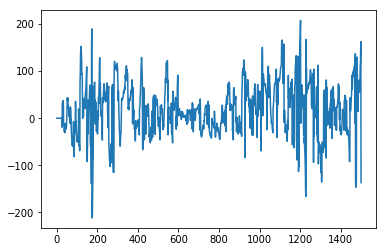

Using price as our spread, but this time with dynamic hedge ratios, we see a far more stationary time series

0.5464794651715567


c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide


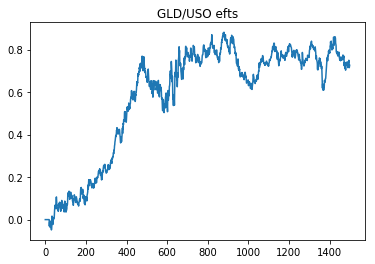

In [64]:
#Test using ernie chans data

import time
def linearTradingStrategyDynamicHedge(df, lookback): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    A = np.matrix(df)
    
    ratios = []
    for i in range(len(A)):
#         if i > lookback:
#             johansenTest = coint_johansen(A[i-lookback:i],0,2, print_summary = False)
#             lookbackTemp, marketVal, evec = halfLife_coint(A, johansenTest.evec[:,0])
#             ratios.append(evec)
#         else:
#             ratios.append([0]*len(pd.DataFrame(A[0]).columns))
          
        #testcase:use ols to find hedge ratios instead
        if i > lookback:    
            ewc_Const = sm.add_constant(df['GLD'].values[i-lookback:i]) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
            model = sm.OLS(df['USO'].values[i-lookback:i],ewc_Const).fit()
            hedge_ratio = model.params[1]
            ratios.append(hedge_ratio)
        else:
            ratios.append(0)

    ratios = np.array(ratios)
    spread = np.array(df['USO'])-np.multiply(ratios, np.array(df['GLD']))
    
#spread = np.sum(np.multiply(ratios, A), axis = 1)
    
 
#     plt.plot(spread)
#     plt.show()
#     test case: use the eigenvector from ernie chan's book to make sure our returns are calculated properly
#     lookback, marketVal, evec = halfLife_coint(A, np.array([-1.046,0.76,0.2233]))
#     lookback = 23
    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(lookback)).std())
    marketValMA = np.array(spread.rolling(math.floor(lookback)).mean())
#     plt.plot(marketVal)
#     plt.show()
    
    #calculate negative z score from moving average
    z = -(spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))

    #calculate the 'positions' we would enter at each time step for each asset. i.e. multiply the number of units by the price of each asset
    #num units is a [len(A) x r] matrix, corresponding to the number of units needing to be bought (weighting by eigenvectors)
    #numUnits = np.multiply(ratios,z)
    numUnits = z
    #positions multiplies the price of each asset by the number of units seeking to be owned at each time
    positions = np.multiply(numUnits,A)
    
    #we calculate pnl by first calculating the percent change of price in each asset
    percentChange = np.array(pd.DataFrame(A).diff())/A
    #then we multiply the percent change by the value of our initial investment (previous timestep), for the pnl
    pnl = np.sum(np.multiply(np.array(pd.DataFrame(positions).shift(1)), percentChange), axis=1)
    pnl = np.nan_to_num(pnl)
    #finally, to calculate the returns, we find the value of our initial investment (divie pnl by the summed rows of positions array)
    prevInvestmentValue= np.array((pd.DataFrame(np.sum(np.abs(np.nan_to_num(np.array(pd.DataFrame(positions).shift(1)))), axis=1))))
    returns = np.divide(pnl, prevInvestmentValue)
    returns = np.nan_to_num(returns)
    
    #to calculate the cumulative returns:
    cumulativeReturns = np.cumsum(returns, axis=0)
    
    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe

# #ernie chan's data
# plot, sharpe = linearTradingStrategyDynamicHedge(df_ernie, lookback = 35)
# print(sharpe)
# plt.plot(plot)
# plt.title('Ernie - ewa/ewc/ige')
# plt.show()

plot, sharpe = linearTradingStrategyDynamicHedge(df_glduso, lookback = 20)
print(sharpe)
plt.plot(plot)
plt.title('GLD/USO efts')
plt.show()

# plt.plot(linearTradingStrategyDynamicHedge(df_5m[:int(len(df_5m)/100)], lookback = 350))
# plt.title('Crypto 5m - btc/usdt, eth/btc, xmr/btc')
# plt.show()


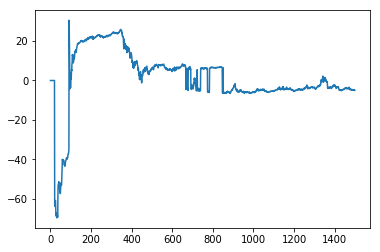

0.42140017585316714


c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


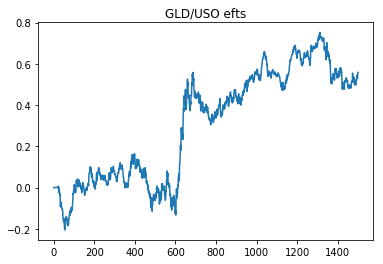

In [71]:
import time
def linearTradingStrategyDynamicHedge(df, lookback): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    A = np.matrix(df)
    
    ratios = []
    lookbacks = []
    for i in range(len(A)):
        if i > lookback:
            johansenTest = coint_johansen(A[:i],0,2, print_summary = False)
            lookbackTemp, marketVal, evec = halfLife_coint(A, johansenTest.evec[:,0])
            ratios.append(evec)
            lookbacks.append(math.floor(lookbackTemp))
        else:
            ratios.append([0]*len(pd.DataFrame(A[0]).columns))
          
    
    ratios = np.array(ratios)  
    spread = np.sum(np.multiply(ratios, A), axis = 1)
    plt.plot(spread)
    plt.show()

    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(20)).std())
    marketValMA = np.array(spread.rolling(math.floor(20)).mean())
#     plt.plot(marketVal)
#     plt.show()
    
    #calculate negative z score from moving average
    z = -(spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))

    #calculate the 'positions' we would enter at each time step for each asset. i.e. multiply the number of units by the price of each asset
    #num units is a [len(A) x r] matrix, corresponding to the number of units needing to be bought (weighting by eigenvectors)
    #numUnits = np.multiply(ratios,z)
    numUnits = z
    #positions multiplies the price of each asset by the number of units seeking to be owned at each time
    positions = np.multiply(numUnits,A)
    
    #we calculate pnl by first calculating the percent change of price in each asset
    percentChange = np.array(pd.DataFrame(A).diff())/A
    #then we multiply the percent change by the value of our initial investment (previous timestep), for the pnl
    pnl = np.sum(np.multiply(np.array(pd.DataFrame(positions).shift(1)), percentChange), axis=1)
    pnl = np.nan_to_num(pnl)
    #finally, to calculate the returns, we find the value of our initial investment (divie pnl by the summed rows of positions array)
    prevInvestmentValue= np.array((pd.DataFrame(np.sum(np.abs(np.nan_to_num(np.array(pd.DataFrame(positions).shift(1)))), axis=1))))
    returns = np.divide(pnl, prevInvestmentValue)
    returns = np.nan_to_num(returns)
    
    #to calculate the cumulative returns:
    cumulativeReturns = np.cumsum(returns, axis=0)
    
    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe

# #ernie chan's data
# plot, sharpe = linearTradingStrategyDynamicHedge(df_ernie, lookback = 35)
# print(sharpe)
# plt.plot(plot)
# plt.title('Ernie - ewa/ewc/ige')
# plt.show()

plot, sharpe = linearTradingStrategyDynamicHedge(df_glduso, lookback = 20)
print(sharpe)
plt.plot(plot)
plt.title('GLD/USO efts')
plt.show()

# plt.plot(linearTradingStrategyDynamicHedge(df_5m[:int(len(df_5m)/100)], lookback = 350))
# plt.title('Crypto 5m - btc/usdt, eth/btc, xmr/btc')
# plt.show()


For some reason, using the johansen test on a window of 20 days doesn't work. It's also problematic because the lookback changes for each window, so calculating the moving average becomes difficult. We need a better way to calculate the hedge ratios, because statically - and dynamically - the Johansen test isn't so fresh. And least squares is pussy ass FOH.

## Bollinger Bands
In our previous trading strategies, we entered a trade at every time step. Bollinger bands put a minimum z-distance (entry score) away from the moving average before we can enter a trade, and similarly an exit score is defined. This parameter is a free parameter, and can be optimized manually. At any one time, we can either have one - or zero - units of portfolio invested, so its very easy to allocate capital to this strategy.

1.2354553260951995


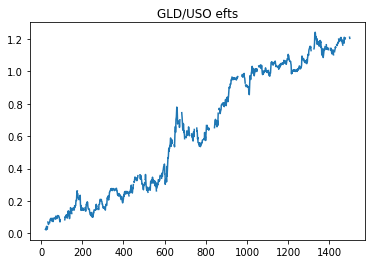

In [8]:
#Test using ernie chans data

import time
def linearTradingStrategyDynamicHedge(df, lookback): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    A = np.matrix(df)
    ratios = []
    for i in range(len(A)):
         #testcase:use ols to find hedge ratios instead
        if i > lookback:    
            ewc_Const = sm.add_constant(df['GLD'].values[i-lookback:i]) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
            model = sm.OLS(df['USO'].values[i-lookback:i],ewc_Const).fit()
            hedge_ratio = model.params[1]
            ratios.append(hedge_ratio)
        else:
            ratios.append(0)

    #for each 1 unit of USO, we hedge with the regressed values of GLD
    ratios = pd.DataFrame(-np.array(ratios))
    ratios['USO'] = pd.Series([1]*len(ratios))
    ratios.columns = ['GLD','USO']

    spread = np.array(df['USO'])+np.multiply(np.array(ratios['GLD']), np.array(df['GLD']))    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(lookback)).std())
    marketValMA = np.array(spread.rolling(math.floor(lookback)).mean())
    #calculate negative z score from moving average
    z = (spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))
    #BOLLINGER BAND COMPONENT
    entryZscore = 1
    exitZscore = 0
    
    longsEntry = z < -entryZscore    # a long position means we should buy USO
    longsExit = z >= -exitZscore     # sell our long position
    
    shortEntry = z > entryZscore     # create a short position, sell GLD
    shortExit = z <= exitZscore      # buy back our short
    
    numUnitsLong = np.array([[np.nan]]*len(z))
    numUnitsShort = np.array([[np.nan]]*len(z))
    
    numUnitsLong[0] = 1
    numUnitsLong[np.array(longsEntry)] = 1
    numUnitsLong[np.array(longsExit)] = 0
    
    numUnitsShort[0] = 1
    numUnitsShort[np.array(shortEntry)] = -1
    numUnitsShort[np.array(shortExit)] = 0
    
    #use pandas , .fillna(method='ffill') 
    for i in range(len(numUnitsLong)):
        if np.isnan(numUnitsLong[i][0]):
            numUnitsLong[i][0] = numUnitsLong[i-1] 
        if np.isnan(numUnitsShort[i][0]):
            numUnitsShort[i][0] = numUnitsShort[i-1] 

    numUnitsPortfolio = (numUnitsShort + numUnitsLong)
    numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.array(ratios))
    positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))
    
    #we calculate pnl by first calculating the percent change of price in each asset
    pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
    pnl = pnl.sum(axis=1)
    
    #returnzzzz bruh
    returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
    cumulativeReturns = np.cumsum(returns, axis=0)


    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe


plot, sharpe = linearTradingStrategyDynamicHedge(df_glduso, lookback = 20)
print(sharpe)
plt.plot(plot)
plt.title('GLD/USO efts')
plt.show()




# Kalman Filters
We've faced the problem of attemping to determine the hedge ratios for each time step. This is because we wish to have a dynamic hedge ratio, forcing us to use regression - as we saw that the Johansen test wasn't so reliable over short timeframes (plus it gave rise to the issue of changing lookbacks). That is why the lord jesus invented kalman filters. Another benefit of the Kalman filter is that we don't need to pick an arbitrary cutoff point for our Mean and Std calculations. Another possible solution to this cutoff problem is to use EMA, which uses a weighting scheme giving more weight to the most recent data, and less weight (exponentially trending down) to preceeding data. However, the choice of exponential decay for the EMA is seemingly arbitrary too, so we'll use Kalman.
Kalman filters, much like HMM, use a hidden state and an observation variable. The value of the hidden variable is updated based upon the latest observation. It's linear, as it assumes the observable is a linear function of the hidden, plus noise. It also assumes the hidden variable at time t is a linear function of itself at time t-1. Due to these linearities, the expected value of the hidden variable at t is a linear function of its expected value prior to t, as well as a linear function of the observed variable at t. Kalman Filters are the BLUE if we assume gaussian noise. 
	
platz on Jan 21, 2017 | parent | favorite | on: How a Kalman filter works, in pictures (2015)

-- Kalman Filters vs HMM (Hidden Markov Model):
"In both models, there's an unobserved state that changes over time according to relatively simple rules, and you get indirect information about that state every so often. In Kalman filters, you assume the unobserved state is Gaussian-ish and it moves continuously according to linear-ish dynamics (depending on which flavor of Kalman filter is being used). In HMMs, you assume the hidden state is one of a few classes, and the movement among these states uses a discrete Markov chain. In my experience, the algorithms are often pretty different for these two cases, but the underlying idea is very similar."

#### Parameters:

   Observable Variable (vector): $y(t) = ( y(1), y(2), ... , (y(N) )^T$, a Nx1 matrix. This is one of 2 time series.
  
   Observation Model (vector):  $x(t) = ( x(1), x(2), ... , (x(N) )^T$, a Nx1 matrix. This is the other time series. We'll actually make x(t) a Nx2 matrix, with the second column being all ones, to allow for constant offset between x and y.
    
   Hidden Variable (vector): $\beta = (\mu, c)^T$, a 2x1 vector, since we allow for constant offset between x and y, we include a constant (c) as well as the slope relating the two time series ($\mu$).
    
   State Transition Model (matrix): How does the hidden variable change with each time step

We can then write the linear function relating y and x as $$y(t) = x(t) \beta(t) + \epsilon(t)$$
$\epsilon(t)$ is of course just gaussian noise, with covariance $V_{\epsilon}$. We now make the crucial assumption that the hidden variable, our regression coefficient $\beta$, at time $t$ is the same as at time $t-1$, plus some noise.. Hence, the state transition matrix is just the identity. Hence, $$\beta(t) = \beta(t-1) + \omega (t-1)$$, with $\omega (t-1)$ being gaussian noise with but with covariance $V_{\omega}$.

#### Trading Model

Our $\beta$ vector will not only give us the dynamic hedge ratio, $\mu$, but we also obtain an estimate for the moving average in the constant of the fit, and we also get an estimate of the standard error in the standard deviation of the observable variable.
    
Quick Maffs (iterative model):
    
   We denote the expected value of $\beta$ at time $t$ giventhe observation at $t-1$ as $\hat{\beta}(t | t-1)$, the expected value of $\beta$ given observation at t as $\hat{\beta}(t | t)$, and the expected value of $y(t)$ given the observation at time $t-1$ as $\hat{y}(t | t-1 )$. Given the quantities $\hat{\beta}(t -1 | t-1)$ and $R(t -1 | t-1)$, we can make one step predictions:
   $$ \hat{\beta}(t | t-1) = \hat{\beta}(t -1 | t-1) $$
   $$ R(t|t-1) = R(t-1|t-1) +V_{\omega}$$
   $$ \hat{y}(t) = x(t)\hat{\beta}(t | t-1)$$
   $$ Q(t) = x(t)^T R(t|t-1) x(t) + V_{\epsilon}$$
   
   
   
   where $$R(t|t) = cov(\beta(t)) - \hat{\beta}(t | t)$$. Thus, $R(t|t-1) = cov(\beta(t)) - \hat{\beta}(t | t-1)$ is a measure of the covariance of the error of hidden variable estimates. R will be a 2x2 matrix, since $\beta$ was a 2x1 vector (containing the mean and slope). We can write the forecast error for $y(t)$ given an observation at $t-1$ as $$ e(t) = y(t) - x(t)\hat{\beta}(t | t-1)$$. We can write the variance of the vorecase error as: $$Q(t) = Var(e(t))$$
   
We make a new observation, and update the state parameters and corariances according to:
$$\hat{\beta}(t | t) = \hat{\beta}(t | t-1) + K(t)e(t)$$
$$R(t | t) = R(t | t-1) - K(t)x(t)R(t | t-1)$$
$$K(t) = R(t | t-1)\frac{x(t)}{Q(t)} = R(t | t-1)\frac{x(t)}{Cov(e(t))}$$
$K(t)$ is the Kalman gain. We assume initial conditions:
$$\hat{\beta}(1|0) = 0$$
$$R(0|0) = 0$$
We estimate $V_{\omega}$ and $V_{\epsilon}$ using autocovariance least squares. 

In [ ]:
def Kalman Filter(df): 
    #convert df to a matrix, run a johansen test and retrieve the lookback, marketValue, eigenvector
    y = np.transpose(np.matrix(df['ewc']))
    #augment x to account for constant offset
    x = np.transpose(np.matrix([df['ewa'],[1]*len(df)]))
    
    #measurement prediction
    yhat = [np.nan]*len(df)
    #measurement prediction error variance
    Q = [np.nan]*len(df)
    #measurement prediction error
    e = [np.nan]*len(df)
    #beta matrix
    beta = [[np.nan]*len(df.columns)]*len(df)
    #R is R(t|t)
    R = np.matrix[[np.nan,np.nan],[np.nan,np.nan]]
    
    #delta is a pre-defined value, but can be trained from the dataset, delta of 0 means we're just doing linear regression
    delta = 0.0001
    Vw = delta/(1-delta)*np.diag(np.ones(len(df.columns)))
    Ve = 0.001
    
    #initialise beta
    
    ratios = []
    for i in range(len(A)):
         #testcase:use ols to find hedge ratios instead
        if i > lookback:    
            ewc_Const = sm.add_constant(df['GLD'].values[i-lookback:i]) # we want to add a constant under the assumption that there can be a nonzero off set of the     pair portfolio’s price series
            model = sm.OLS(df['USO'].values[i-lookback:i],ewc_Const).fit()
            hedge_ratio = model.params[1]
            ratios.append(hedge_ratio)
        else:
            ratios.append(0)

    #for each 1 unit of USO, we hedge with the regressed values of GLD
    ratios = pd.DataFrame(-np.array(ratios))
    ratios['USO'] = pd.Series([1]*len(ratios))
    ratios.columns = ['GLD','USO']

    spread = np.array(df['USO'])+np.multiply(np.array(ratios['GLD']), np.array(df['GLD']))    
    #create rolling averages
    spread = pd.DataFrame(spread)
    marketValStd = np.array(spread.rolling(math.floor(lookback)).std())
    marketValMA = np.array(spread.rolling(math.floor(lookback)).mean())
    #calculate negative z score from moving average
    z = (spread - marketValMA)/marketValStd
    #convert nans to 0
    z = np.array(np.nan_to_num(z))
    #BOLLINGER BAND COMPONENT
    entryZscore = 1
    exitZscore = 0
    
    longsEntry = z < -entryZscore    # a long position means we should buy USO
    longsExit = z >= -exitZscore     # sell our long position
    
    shortEntry = z > entryZscore     # create a short position, sell GLD
    shortExit = z <= exitZscore      # buy back our short
    
    numUnitsLong = np.array([[np.nan]]*len(z))
    numUnitsShort = np.array([[np.nan]]*len(z))
    
    numUnitsLong[0] = 1
    numUnitsLong[np.array(longsEntry)] = 1
    numUnitsLong[np.array(longsExit)] = 0
    
    numUnitsShort[0] = 1
    numUnitsShort[np.array(shortEntry)] = -1
    numUnitsShort[np.array(shortExit)] = 0
    
    #use pandas , .fillna(method='ffill') 
    for i in range(len(numUnitsLong)):
        if np.isnan(numUnitsLong[i][0]):
            numUnitsLong[i][0] = numUnitsLong[i-1] 
        if np.isnan(numUnitsShort[i][0]):
            numUnitsShort[i][0] = numUnitsShort[i-1] 

    numUnitsPortfolio = (numUnitsShort + numUnitsLong)
    numUnitsEachAsset = np.multiply(np.tile(numUnitsPortfolio, (1,2)), np.array(ratios))
    positions = pd.DataFrame(np.multiply(numUnitsEachAsset, A))
    
    #we calculate pnl by first calculating the percent change of price in each asset
    pnl = pd.DataFrame(positions).shift(1)*(pd.DataFrame(A) - pd.DataFrame(A).shift(1))/pd.DataFrame(A).shift(1)
    pnl = pnl.sum(axis=1)
    
    #returnzzzz bruh
    returns=pnl / np.sum(np.abs(positions.shift(1)),axis=1)
    cumulativeReturns = np.cumsum(returns, axis=0)


    sharpe = math.sqrt(252)*np.mean(returns)/np.std(returns)
    return cumulativeReturns, sharpe


plot, sharpe = linearTradingStrategyDynamicHedge(df_ernie[['ewc','ewa']])
print(sharpe)
plt.plot(plot)
plt.title('EWC/EWA efts')
plt.show()


In [14]:
len(np.matrix(df_ernie['ewc']))

1

In [11]:
np.transpose(np.matrix([df_ernie['ewa'],[1]*len(df_ernie)]))

matrix([[16.1 ,  1.  ],
        [15.98,  1.  ],
        [16.1 ,  1.  ],
        ...,
        [22.98,  1.  ],
        [23.12,  1.  ],
        [22.93,  1.  ]])

In [16]:
[[np.nan,np.nan]]*len(df_ernie)

[[nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],
 [nan, nan],

[[nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan, nan],
 [nan, nan

In [21]:
np.diag(np.ones(2))

array([[1., 0.],
       [0., 1.]])